# Categorization of the beer users

In this part of the analysis, the objective is to categories the users. These categories of users will be the different shelves that each supermaket will have to put in its beers aisle. The different categories that we think can be relevant for the customers are 'experienced beer consumers' which will target the customers which are familiar with beers and consider themselves as regular consumers. 'Novice beer consumers' which on the other hand are rather less accustomed to beer consumption. Another category to showcase is 'explorator beer consumers' which targets all customers which want to try a new kind of beer and want to discover something new. The analysis for this category is based on the users which tend to rate beers that are less popular. Finally, the category 'nationalist' doens't require any processing on the users but will be used to distonguish the supermarket according to their country. It will thus be used to showcase all the beers that are the most popular in the country we are in. 

#### Import libraries

In [4]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from tqdm import tqdm

sns.set()
sns.set_style("whitegrid")
colors = sns.color_palette("colorblind", 16)

RAW_DATA_FOLDER = '../data/raw/'
PROCESSED_DATA_FOLDER = '../data/processed/'
DATASET = 'BeerAdvocate/'

#### Imports datasets

In order to categorize the users, we need the information about the users given by the dataset `users`. Similarly, one needs the information about the beers (dataset `beers`) and the ratings of the beers (dataset `ratings`).

In [8]:
users = pd.read_pickle(PROCESSED_DATA_FOLDER + DATASET + 'users.pkl')
beers = pd.read_pickle(PROCESSED_DATA_FOLDER + DATASET + 'beers.pkl')
ratings = pd.read_pickle(PROCESSED_DATA_FOLDER + DATASET + 'ratings.pkl')

In this step, we only want to keep one row per user and per beer in the `users` and `beers` datasets respectively. Concerning the `ratings` dataset, given the fact that a user can rate the same beer at different dates, we don't want to count the number of times a given user rates a given beer but rather how many beers in total a given user rated. Therefore, for each rating we keep the first one if multiple have the same beer_id and user_id.

In [9]:
users.drop_duplicates(subset=['user_id'], inplace=True)
beers.drop_duplicates(subset=['beer_id'], inplace=True)
ratings.drop_duplicates(subset=['beer_id', 'user_id'], inplace=True)

### Analysis of the users dataset 

* **Distribution of the users per country:** For the users it can be interesing to check how are the users distributed over the different countries. For the USA, the distribution is done over the different states.

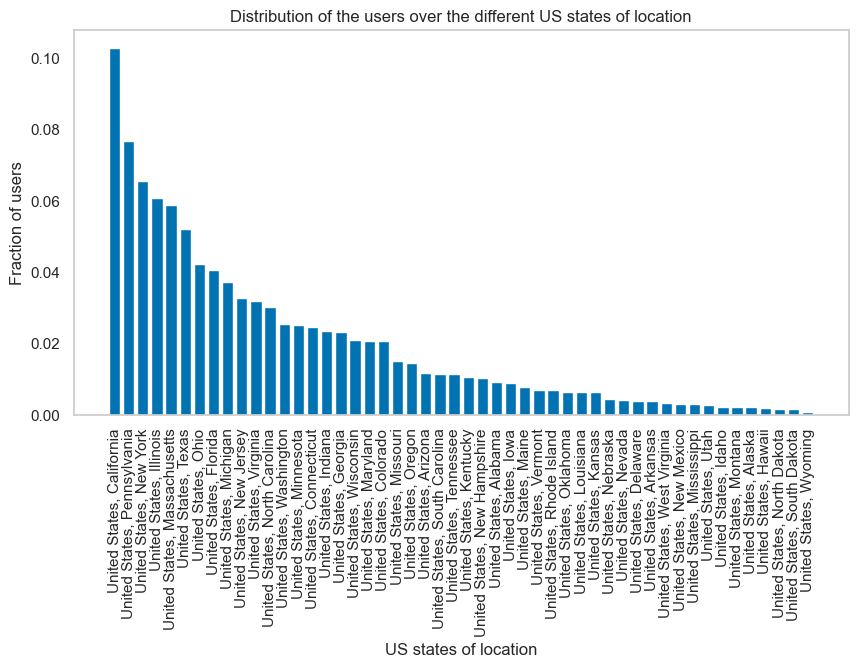

In [9]:
US_users = users[users['location'].str.contains('United States')==True]
US_users_per_location = US_users.location.value_counts()/len(US_users)

plt.figure(figsize=(10,5))
plt.bar(US_users_per_location.index, US_users_per_location.values, color=colors[0], align='center')
plt.xticks(rotation=90)
plt.xlabel('US states of location')
plt.ylabel('Fraction of users')
plt.title('Distribution of the users over the different US states of location')
plt.grid(False)
plt.show()

In [10]:
users.loc[users.location.str.contains('United States')==True, 'location'] = 'United States'
users_per_location = users.location.value_counts().to_frame().reset_index().rename(columns={'index':'country', 'location':'count'})
users_per_location.loc[users_per_location['count'] <10, 'country'] = 'others'
users_per_location = users_per_location.groupby('country').sum().reset_index().sort_values(by='count', ascending=False)

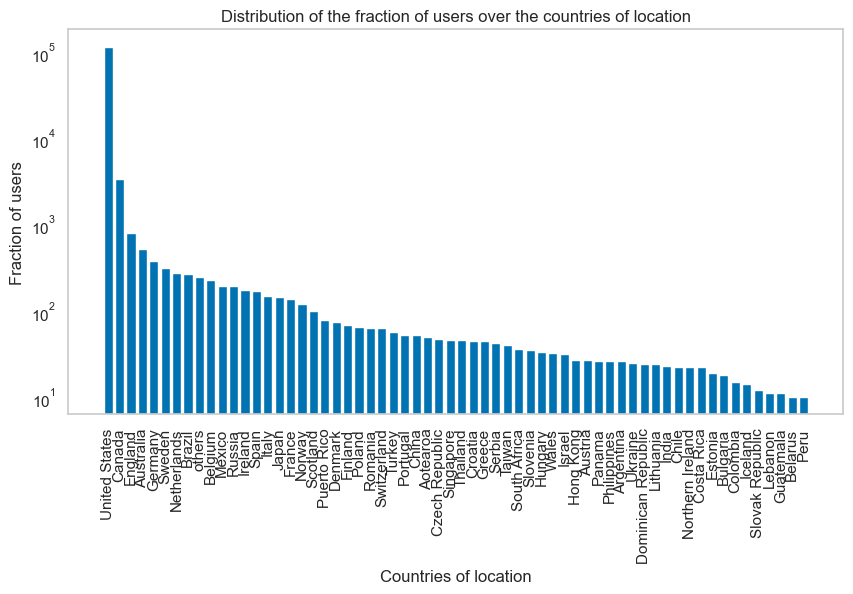

In [11]:
plt.figure(figsize=(10,5))
plt.bar(users_per_location.country, users_per_location['count'], color=colors[0])
plt.xticks(rotation=90)
plt.yscale('log')
plt.xlabel('Countries of location')
plt.ylabel('Fraction of users')
plt.title('Distribution of the fraction of users over the countries of location')
plt.grid(False)
plt.show()

The information given by each dataset is processed specifically to only draw the usefull elements. Thus,

* Dataset `users`: Used for the users ids, and their level of expertise (number of ratings for each user)
* Dataset `beers`: Used to get the number of ratings of each beer
* Dataset `ratings`: Used to know which beers have been rated and by whom

### Determine which beers have been rated by each user

We now create a dataframe which will gather all the required informlation for further analysis. Thus, for each user, we want how many ratings does he have and which beers did he try.

In [46]:
merged_data = users[['user_id', 'nbr_ratings']]
merged_data = merged_data.merge(ratings[['user_id', 'beer_id']], on='user_id')
merged_data

,user_id,nbr_ratings,beer_id
0,nmann08.184925,7820,142544
1,nmann08.184925,7820,120824
2,nmann08.184925,7820,47581
3,nmann08.184925,7820,93113
4,nmann08.184925,7820,875
...,...,...,...
8393027,everman.532342,1,70471
8393028,justin0001.352175,1,61818
8393029,kyungsup.982216,1,61817
8393030,joetex.800347,1,61815


### Categorize the users

#### STEP 1: First step is to define each category and according to which threshold is a user considered as part of a given category.

#### Experienced beer consumers

A user is considered as experienced according to his number of ratings. Indeed, th number of ratings gives an idea about how many beers the user tryied and therefore what is his experience.

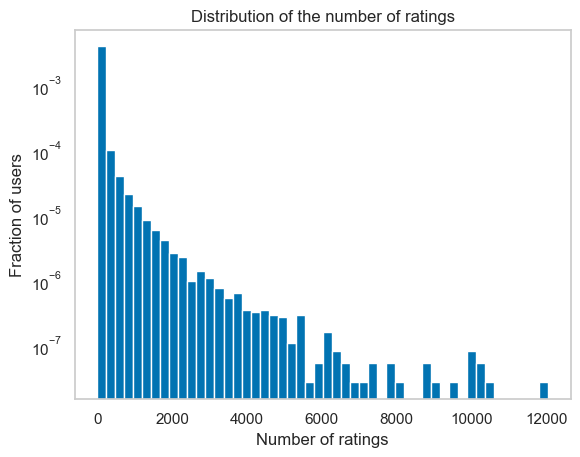

In [17]:
users.nbr_ratings.hist(density=True, bins=50, color=colors[0])
plt.yscale('log')
plt.ylabel('Fraction of users')
plt.xlabel('Number of ratings')
plt.title('Distribution of the number of ratings')
plt.grid(False)
plt.show()

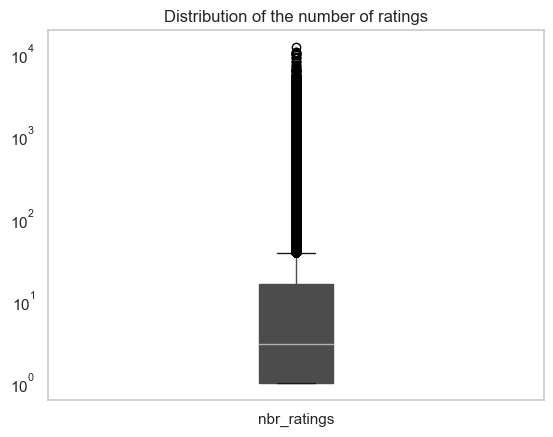

Number of ratings at the different quantiles:


0.00        1.0
0.25        1.0
0.50        3.0
0.75       16.0
1.00    12046.0
Name: nbr_ratings, dtype: float64

In [18]:
users.boxplot(column=['nbr_ratings'], patch_artist=True)
plt.yscale('log')
#plt.ylim([0,50])
plt.title('Distribution of the number of ratings')
plt.grid(False)
plt.show()

print('Number of ratings at the different quantiles:')
users.nbr_ratings.quantile([0,0.25,0.5,0.75,1])

In view of the distribution of the number of ratings for the different users, one considers that a user is categorized as an experienced beer consummer if he's considered as outlier when visualizing the ratings distribution using the boxplot. Hence, all users with number of ratings outside 1.5 times the interquartile range above the upper quartile are considered as experienced. Therefore, the experienced threshold is set at Q3 + 1.5 * IQR = Q3 + 1.5 * (Q3-Q1) = 16+1.5 * (16-1) = 39.

In [19]:
print('The experienced beers consumers represent {:.2f}% of the total users in the dataset.'.format(len(users[users.nbr_ratings>39])/len(users) * 100))

The experienced beers consumers represent 15.81% of the total users in the dataset.


#### Novice

Similarly to the experienced users, arbitrarly, an in view of the number of ratings distribution, all users with number of ratings below the median which is set at 3 ratings are considered as novice/beginners.

#### Explorator
A user is considered as explorator if he tends to rate beers that are not that popular. 

In [23]:
ratings_per_beer = ratings.groupby('beer_id')['beer_id'].agg(['count']).reset_index().rename(columns={'count':'nbr_ratings'})

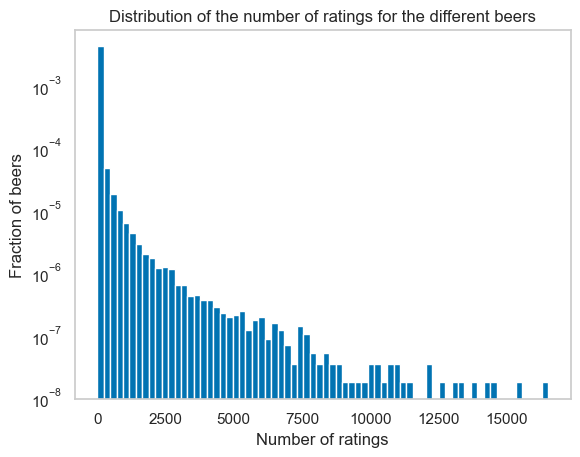

In [21]:
ratings_per_beer.nbr_ratings.hist(density=True, bins=70, color=colors[0])
plt.yscale('log')
plt.ylabel('Fraction of beers')
plt.xlabel('Number of ratings')
plt.title('Distribution of the number of ratings for the different beers')
plt.grid(False)
plt.show()

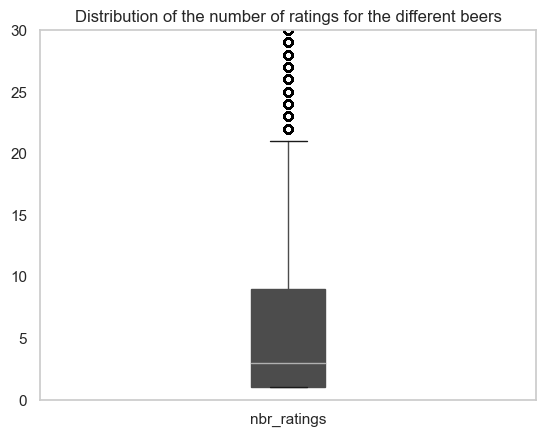

Number of ratings at the different quantiles:


0.00        1.0
0.25        1.0
0.50        3.0
0.75        9.0
1.00    16509.0
Name: nbr_ratings, dtype: float64

In [22]:
ratings_per_beer.boxplot(column=['nbr_ratings'], patch_artist=True)
#plt.yscale('log')
plt.ylim([0,30])
plt.title('Distribution of the number of ratings for the different beers')
plt.grid(False)
plt.show()

print('Number of ratings at the different quantiles:')
ratings_per_beer['nbr_ratings'].quantile([0,0.25,0.5,0.75,1])

In [23]:
print('The most popular and rated beers represent {:.2f}% of the total number of beers in the dataset.'.format(len(ratings_per_beer[ratings_per_beer.nbr_ratings>21])/len(ratings_per_beer) * 100))

The most popular and rated beers represent 14.53% of the total number of beers in the dataset.


In [24]:
print('{:.2f}% of the total number of beers in the dataset have less than 10 ratings which is negligeable.'.format(len(ratings_per_beer[ratings_per_beer.nbr_ratings<10])/len(ratings_per_beer) * 100))

75.32% of the total number of beers in the dataset have less than 10 ratings which is negligeable.


In view of the distribution of the the number of ratings per beer, one notices the heavy-tail of the distribution. Thus, almost 75% of the beers have less than 10 ratings which is already almost half of the number of ratings than the least popular beer among all the most rated beers. Thereforen a bit arbitrarly, we consider all beers with under 10 ratings as 'scarce beers'. Thus, if a user has rated one of these beers, he's considered as an explorator.

In [47]:
ratings_per_beer['scarce_beer'] =  ratings_per_beer['nbr_ratings'].apply(lambda x: True if x<10 else False)
ratings_per_beer

,beer_id,nbr_ratings,scarce_beer
0,3,3,True
1,4,10,False
2,5,1680,False
3,6,2894,False
4,7,3293,False
...,...,...,...
247977,293285,1,True
247978,293286,1,True
247979,293294,1,True
247980,293295,1,True


#### STEP 2: Once the different categories defined, we can now categories the users.

* Categories users into experienced, novice or none of them directly on the users dataset

In [25]:
users['experienced_user'] = users['nbr_ratings'].apply(lambda x: True if x>39 else False)
users['novice_user'] = users['nbr_ratings'].apply(lambda x: True if x<3 else False) 

* Categories users into explorator or not and add this feauture to the the users dataset

In [ ]:
users['explorator']=False

for group_user_id, group in tqdm(merged_data.groupby('user_id')):
    user = " "
    user = user.join(group.user_id.unique())
    for beer in group.beer_id:
        if ratings_per_beer.loc[ratings_per_beer.beer_id == beer,'scarce_beer'].bool():
            users.loc[users.user_id == user, 'explorator'] = True
            break

In [48]:
merged_data = merged_data.merge(ratings_per_beer[['beer_id', 'scarce_beer']], on='beer_id')

In [53]:
is_explorator = merged_data.groupby('user_id')['scarce_beer'].sum() >= 1 
users['explorator'] = users.user_id.apply(lambda x: is_explorator[x])

In [54]:
users

,nbr_ratings,nbr_reviews,user_id,user_name,joined,location,experienced_user,novice_user,explorator
0,7820,465,nmann08.184925,nmann08,1.199704e+09,"United States, Washington",True,False,True
1,2521,2504,stjamesgate.163714,StJamesGate,1.191838e+09,"United States, New York",True,False,True
2,1797,1143,mdagnew.19527,mdagnew,1.116410e+09,Northern Ireland,True,False,True
3,31,31,helloloser12345.10867,helloloser12345,1.101380e+09,Northern Ireland,False,False,True
4,604,604,cypressbob.3708,cypressbob,1.069326e+09,Northern Ireland,True,False,True
...,...,...,...,...,...,...,...,...,...
153699,1,1,everman.532342,Everman,1.291115e+09,"United States, California",False,True,False
153700,1,1,justin0001.352175,Justin0001,1.248343e+09,"United States, California",False,True,False
153701,1,0,kyungsup.982216,Kyungsup,1.430561e+09,NaN,False,True,False
153702,1,1,joetex.800347,JoeTex,1.400234e+09,"United States, California",False,True,False
